# Practical 2 : Generative and Discriminative Models


In this practical, we will compare the Naïve Bayes Classifier (NBC) and Logistic Regression on several
datasets. As part of the practical you should read briefly the following paper:



**On Discriminative vs. Generative classifiers: A comparison of logistic regression
and naive Bayes**  
*Andrew Y. Ng and Michael I. Jordan*  
Advances in Neural Information Processing Systems (NIPS) 2001.

The paper is available on OLAT. 

You should read the Introduction and the Experiments sections. The goal of this practical is
to qualitatively reproduce some of the experimental results in this paper. You are strongly
encouraged to read the rest of the paper, which is rather short and straightforward to read,
though some of you may want to skip the formal proofs.

## Naïve Bayes Classifier (NBC)

You should implement a Naïve Bayes Classifier from scartch using NumPy. To keep your code tidy,
we recommend implementing it as a class. 
The classifier should be able to handle binary and continuous features. 
To earn the bonus points, the classifier should be able to handle categorical features as well. 
Suppose the data has 3
different features, the first being binary, the second being continuous and the third being categorical. Write an implementation that you can initialise as follows:

    nbc = NBC(feature_types=['b', 'r', 'c'])

Along the lines of classifiers provided in sklearn, you want to implement two more functions,
**fit** and **predict**. 
Recall the joint distribution of a generative model: $p(\mathbf{x}, y \mid \theta, \pi) = p(y \mid \pi) \cdot p(\mathbf{x} \mid y, \theta)$.
The **fit** function is to estimate all the parameters ($\theta$ and $\pi$) of the NBC, i.e., train the classifier. The **predict** function computes the probabilities that the new input belongs to all classes and
then returns the class that has the largest probability, i.e., makes a prediction.

    nbc.fit(X_train, y_train)
    ypredicted = nbc.predict(X_test)
    test_accuracy = np.mean(ypredicted == ytest)

Here we import the libraries. 

In [38]:
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (10., 10.)

import pickle as cp
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import norm, bernoulli, multinomial
from scipy.special import logsumexp

### Class-conditional distributions

Before implementing NBC, we first implement the class-conditional distributions $p(\mathbf{x} \mid y, \theta)$. Your implementation should have two functions: **estimate** and **get_log_probability**. 

- The **estimate** function takes data as input and models the data using some distribution $p(x \mid \theta)$, where $\theta$ is the parameters of this distribution. The function estimates the parameters $\theta$ using maximum likelihood estimators (MLE). 
For example, in the case of continuous features, we use the Gaussian distribution to model the data. The estimate function will find the parameters $\mu$ and $\sigma$ for the Gaussian distribution with respect to the input data. 

- The **get_log_probability** function takes as input a new data point $x_{new}$ and returns the log of $p(x_{new} \mid \theta)$. For the Gaussian distribution, the function get_probability will return $\mathcal{N}(x_{new} \mid \mu, \sigma^2)$. 

For different types of features, you need to use different distributions.
You can import statistic libraries (e.g., `scipy.stats`) for the implementation of the distributions. 

- For **continuous features**: Use Gaussian distribution
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html
- For **binary features**: Use Bernoulli distribution 
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bernoulli.html
- For **categorical features**: Use Multinoulli distribution (The multinoulli distribution is a special case of the multinomial distribution, where the number of trials is 1)
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multinomial.html

Example: https://stackoverflow.com/questions/12412895/how-to-calculate-probability-in-a-normal-distribution-given-mean-standard-devi


**Implementation Issues:**
- The probabilities can be very small. To avoid underflow issues, you should compute the log of the probabilities. Read more: (Mur) Chapter 3.5.3 / Lecture Notes
- The variance for Gaussian distributions should never be exactly 0, so in
case your calculated variance is 0, you may want to set it to a small value such as 1e − 6. This is to ensure that your code never encounters division by zero or
taking logarithms of 0 errors. 
For this practical, please set the small value to 1e-6.
- Laplace/Additive smoothing: You want to ensure that the estimates for the parameter for the Bernoulli and Multinoulli random variables is never exactly 0 or 1. For this reason you should consider using Laplace smoothing (https://en.wikipedia.org/wiki/Additive_smoothing).
For this practical, please set alpha to 1.
- For simplicity, you can assume the data values for binary features are integers from {0,1} and the data for a categorical feature with M categories are integers from {0, ..., M-1}.
- Fell free to add auxiliary functions or change the parameters of the functions. If you change the parameters of the functions, make sure you change the tests accordingly, so we can test your code.


In [39]:
ALPHA = 1.0 # for additive smoothing

# Distribution for continuous features
class ContFeatureParam:
    def estimate(self, X):
        # TODO: Estimate the parameters for the Gaussian distribution 
        # so that it best describes the input data X
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        self.mean, std = norm.fit(X)
        self.std = np.sqrt(1e-6) if std==0 else std#get mean and standard variance of the data
        return self
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

    def get_log_probability(self, X_new):
        # TODO: return the log of the density values for the input values X_new
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        return norm.logpdf(X_new, loc=self.mean, scale=self.std)
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

# Distribution for binary features
class BinFeatureParam:
    def estimate(self, X):
        # TODO: Estimate the parameters for the Bernoulli distribution 
        # so that it best describes the input data X
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        # X is a vector with binary values
        occurences = X.shape[0]
        unique, counts = np.unique(X, return_counts=True)#Assume that the input belong to {0,1}
        if unique.shape[0] > 2:
            raise AssertionError("more than 2 categories in binary")

        self.prob = (counts[0]+ALPHA) / (occurences + ALPHA*unique.shape[0])# get the frequency of '0' and smoothing
        #self.prob = bernoulli.expect(X)
        return self
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

    def get_log_probability(self, X_new):
        # TODO: return the log of the probability values for the input values X_new
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        return bernoulli.logpmf(X_new, 1 - self.prob)
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

# Distribution for categorical features
class CatFeatureParam:
    
    # we need to know the number of categories for the categorical feature
    def __init__(self, num_of_categories):
        self._num_of_categories = num_of_categories
    
    def estimate(self, X):
        # TODO: Estimate the parameters for the Multinoulli distribution 
        # so that it best describes the input data X
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        times_observed = X.shape[0]
        self.cat_observed, cat_observed_counts = np.unique(X, return_counts=True)
        num_cat_observed = self.cat_observed.shape[0]
        self.prob_vec_observed = (cat_observed_counts + ALPHA) / (times_observed + ALPHA * self._num_of_categories)
        #get the frequency vector of input data and smoothing
        self.prob_not_observed = (1 - sum(self.prob_vec_observed)) / (self._num_of_categories - num_cat_observed) if self._num_of_categories != num_cat_observed else 0
        #for the categories not observed, set the their probabilty to the average of residuals of (1-sum(probabilties))
        return self
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################
        
    def get_log_probability(self, X_new):
        # TODO: return the log of the probability values for the input values X_new
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        times_observing = X_new.shape[0]
        cat_observing, cat_observing_counts = np.unique(X_new, return_counts=True)
        prob_vec_observing = np.zeros((cat_observing.shape[0],))
        for i in range(cat_observing.shape[0]):
            if cat_observing[i] in self.cat_observed:
                prob_vec_observing[i] = self.prob_vec_observed[np.argwhere(self.cat_observed==cat_observing[i])]
            else:
                prob_vec_observing[i]=self.prob_not_observed
        #generate probability vector of predicting data
        observing = np.zeros((times_observing, cat_observing.shape[0]))#Build the observing matrix just like one-hot encoding
        for i in range(times_observing):
            j = np.argwhere(cat_observing==X_new[i])
            observing[i,j] = 1.0
        n = np.ones((times_observing,))
        return multinomial.logpmf(observing, n, prob_vec_observing)
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

**Tests:**
    
We will use the code below to test the correctness of your code.

In [40]:
# continuous features

X = np.array([2.70508547,2.10499698,1.76019132,3.42016431,3.47037973,3.67435061,1.84749286,4.3388506,2.27818252,4.65165335])

param = ContFeatureParam()
param.estimate(X)
probs = param.get_log_probability(np.array([0,1,2,3]))
print(probs)

[-5.64670664 -3.02757918 -1.44567455 -0.90099277]


In [41]:
# binary features

X = np.array([0,0,1,1,0,1,0,1,1,1])

param = BinFeatureParam()
param.estimate(X)
probs = param.get_log_probability(np.array([0,1]))
print(probs)

[-0.87546874 -0.5389965 ]


In [42]:
# categorical features (bonus task)

X = np.array([0,6,5,4,0,6,6,4,1,1,2,3,8,8,1,6,4,9,0,2,2,3,8,0,2])

param = CatFeatureParam(num_of_categories=10)
param.estimate(X)
probs = param.get_log_probability(np.array([0,1,2,3,4,5,6,7,8,9]))
print(probs)

[-1.94591015 -2.1690537  -1.94591015 -2.45673577 -2.1690537  -2.86220088
 -1.94591015 -3.55534806 -2.1690537  -2.86220088]


### Implement NBC

We are now ready to implement NBC. We follow the structure of models in scikit-learn. We implement NBC as a class with functions **init**, **fit** and **predict**.
The **init** function takes as input the types of features and initialise the classifier. The **fit** function takes the training data as input and estimates the parameters. The **predict** function predicts the label for the input data. 

**Implementation Issues:**
- You should use matrix operations rather than loops. In general, loops over classes or features are OK, but loops over the rows of data are not a good idea.
- The probabilities can be very small. To avoid underflow issues, you should do the calculations in log space. Read more: (Mur) Chapter 3.5.3 / Lecture Note
- For simplicity, you can assume the data values for binary features are integers from {0, 1} and the data for a categorical feature with M categories are integers from {0, ..., M-1}.
- Fell free to add auxiliary functions or change the parameters of the functions. If you change the parameters of the functions, make sure you change the tests accordingly, so we can test your code.

In [61]:
# Your task is to implement the three functions of NBC. 

class NBC:
    # Inputs:
    #   feature_types: the array of the types of the features, e.g., feature_types=['b', 'r', 'c']
    def __init__(self, feature_types=[]):
        # TODO: 
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        self.feature_types = feature_types
        self.feature_num = len(feature_types)
        self.model_list = []
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

        
    # The function uses the input data to estimate all the parameters of the NBC
    def fit(self, X, y):
        # TODO: 
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        self.y_unique, y_count = np.unique(y, return_counts=True)
        self.y_log_probability = np.log(y_count/sum(y_count))
        model_list=[]
        for y_idx in range(self.y_unique.shape[0]):
            sub_model_list=[]
            for i in range(self.feature_num):
                X_obs = np.array(X[y == self.y_unique[y_idx], i]) # observations in X for specific class and feature
                if self.feature_types[i] == 'r':
                    sub_model_list.append(ContFeatureParam().estimate(X_obs))
                if self.feature_types[i] == 'b':
                    sub_model_list.append(BinFeatureParam().estimate(X_obs))
                if self.feature_types[i] == 'c':
                    num_of_cat = max(X[:,i]) + 1
                    sub_model_list.append(CatFeatureParam(num_of_cat).estimate(X_obs))
            model_list.append(sub_model_list)
        self.model_list = model_list
        return self
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################
                
                
    # The function takes the data X as input, and predicts the class for the data
    def predict(self, X):
        # TODO: 
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        numerator = np.zeros((X.shape[0], self.y_unique.shape[0])) + self.y_log_probability
        for i in range(self.y_unique.shape[0]):       #bayes formula
            for j in range(self.feature_num):
                numerator[:,i] += self.model_list[i][j].get_log_probability(X[:,j])
        return self.y_unique[np.argmax(numerator, axis=1)]
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################


**Tests**

We will use the code below to check your code.

In [62]:
# All features of the iris dataset are continuous.

from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris['data'], iris['target']

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]


nbc_iris = NBC(feature_types=['r', 'r', 'r', 'r'])
nbc_iris.fit(Xtrain, ytrain)
yhat = nbc_iris.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 90%
print(yhat)

Accuracy: 0.9333333333333333
[2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [63]:
# All features of this dataset are binary
import pandas as pd
data = pd.read_csv('./datasets/binary_test.csv', header=None)
data = data.to_numpy()

X = data[:,1:]
y = data[:,0]

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]


nbc = NBC(feature_types=['b'] * 16)
nbc.fit(Xtrain, ytrain)
yhat = nbc.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 85%
print(yhat)

Accuracy: 0.8723404255319149
[1 0 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 0 1 1 1 0 1 1 1 0 1 0 1 0
 0 0 1 0 0 0 0 1 1 0]


In [64]:
# All features of this dataset are categorical (bonus task)

data = pd.read_csv('./datasets/categorical_test.csv', header=None)
data = data.to_numpy()

X = data[:,:-1]
y = data[:,-1]

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]


nbc = NBC(feature_types=['c'] * 9)
nbc.fit(Xtrain, ytrain)
yhat = nbc.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 65%
print(yhat) 

Accuracy: 0.7068965517241379
[0 1 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 1 0 0 0 0 1 0
 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0]


## Logistic Regression

For logistic regression (LR), you should use the implementation in scikit-learn. Add the following
line to import the LR model.

In [65]:
from sklearn.linear_model import LogisticRegression

Check the scikit-learn documentation for the Logistic Regression model:
- http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
- http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression


## Comparing NBC and LR

### Experiments

The experiment is to compare the classification error of the NBC and LR trained on increasingly larger training datasets. 
Since the datasets are so small, you should do this multiple times and
average the classification error. One run should look as follows:
- Shuffle the data, put 20% aside for testing.
    
    ```N, D = X.shape
    Ntrain = int(0.8 * N)
    shuffler = np.random.permutation(N)
    Xtrain = X[shuffler[:Ntrain]]
    ytrain = y[shuffler[:Ntrain]]
    Xtest = X[shuffler[Ntrain:]]
    ytest = y[shuffler[Ntrain:]]
    
    ```  


- Train the classifiers with increasingly more data. For example, we can train classifiers with 10%, 20%, ..., 100% of the training data. For each case store the classification errors on the test set of the classifiers.

You may want to repeat this with at least 200 random permutations (possibly as large as 1000)
to average out the test error across the runs. In the end, you will get average test errors as a function of the size of the training data. 
We have written for you the function for making the plots for the experiments. 

In [66]:
# inputs:
#   nbc: Naive Bayes Classifier
#   lr: Logistic Regression Classifier
#   X, y: data
#   num_runs: we need repeat num_runs times and store average results
#   num_splits: we want to compare the two models on increasingly larger training sets.
#               num_splits defines the number of increasing steps. 
# outputs:
#   the arrays of the test errors across the runs of the two classifiers 
def compareNBCvsLR(nbc, lr, X, y, num_runs=200, num_splits=10):
    # The code below is just for compilation. 
    # You need to replace it by your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    tst_errs_nbc = []
    tst_errs_lr = [] #create the error matrix
    
    for i in range(num_runs):
        
        tst_errs_nbc_temp = []
        tst_errs_lr_temp = [] # error rate array for each run
        
        for j in range(num_splits):
            N,D = X.shape
            Ntrain_init = int(0.8 * N)
            shuffler = np.random.permutation(N)
            Xtrain_init = X[shuffler[:Ntrain_init]]
            ytrain_init = y[shuffler[:Ntrain_init]]
            Xtest = X[shuffler[Ntrain_init:]]
            ytest = y[shuffler[Ntrain_init:]]
            

            Ntrain = int((j+1)/ num_splits * Xtrain_init.shape[0])
            shuffler = np.random.permutation(Xtrain_init.shape[0])
            Xtrain = Xtrain_init[shuffler[:Ntrain]]
            ytrain = ytrain_init[shuffler[:Ntrain]]
            
            while(len(np.unique(ytrain)) < 2):
                shuffler = np.random.permutation(Xtrain_init.shape[0])
                Xtrain = Xtrain_init[shuffler[:Ntrain]]
                ytrain = ytrain_init[shuffler[:Ntrain]]
            
            nbc.fit(Xtrain, ytrain)
            lr.fit(Xtrain, ytrain)#train the models
            y_nbc_predict = nbc.predict(Xtest)
            y_lr_predict = lr.predict(Xtest)#get the predict outcome
            
            tst_errs_nbc_temp.append(np.mean(y_nbc_predict != ytest))
            tst_errs_lr_temp.append(np.mean(y_lr_predict != ytest))
        
        tst_errs_nbc.append(tst_errs_nbc_temp)
        tst_errs_lr.append(tst_errs_lr_temp)
    
    tst_errs_nbc = np.mean(tst_errs_nbc, axis = 0)
    tst_errs_lr = np.mean(tst_errs_lr, axis = 0)
            
    return tst_errs_nbc, tst_errs_lr
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################

In [67]:
def makePlot(tst_errs_nbc, tst_errs_lr, title=None, num_splits=10):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.tick_params(axis='both', labelsize=20)

    ax.set_xlabel('Percent of training data used', fontsize=20)
    ax.set_ylabel('Classification Error', fontsize=20)
    if title is not None: ax.set_title(title, fontsize=25)

    xaxis_scale = [(i + 1) * (100/num_splits) for i in range(num_splits)]
    plt.plot(xaxis_scale, tst_errs_nbc, label='Naive Bayes')
    plt.plot(xaxis_scale, tst_errs_lr, label='Logistic Regression', linestyle='dashed')
    
    ax.legend(loc='upper right', fontsize=20)

### Datasets

Tasks: For each dataset,
1. prepare the data for the two classifiers, e.g., handle missing values, handle text/categorical data, etc.
2. compare the two classifiers on the dataset and generate the plots
3. write a short report of how you prepare the data and your observations of the comparison 

**Dataset 1: Iris Dataset**

https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

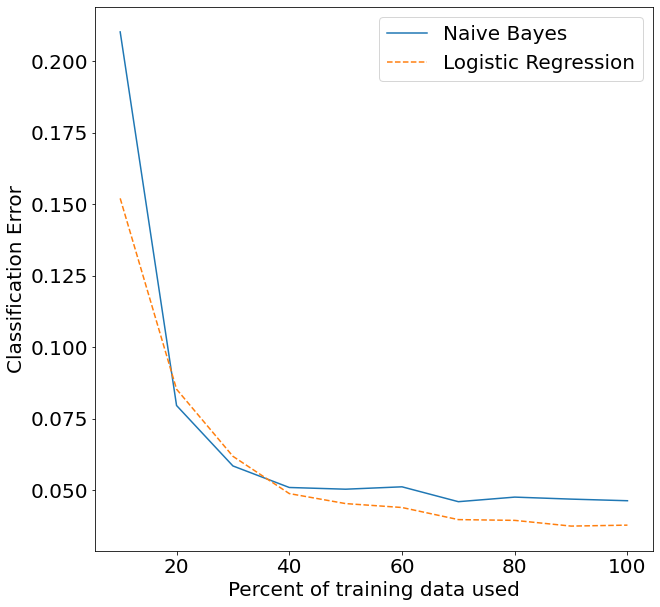

In [68]:
# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
from sklearn.datasets import load_iris
iris_obj = load_iris()
# the code transform the iris dataset to a dataframe
iris = pd.DataFrame(iris_obj.data, columns=iris_obj.feature_names,index=pd.Index([i for i in range(iris_obj.data.shape[0])])).join(pd.DataFrame(iris_obj.target, columns=pd.Index(["species"]), index=pd.Index([i for i in range(iris_obj.target.shape[0])])))
iris.dropna(axis = 0, how = 'any').reset_index() #drop missing values
X=np.array(iris[['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)']].values)
y=np.array(iris[['species']].values.tolist()).T.reshape(len(iris[['species']]))
nbc_iris = NBC(feature_types=['r','r','r','r'])
lr_iris = LogisticRegression(solver='newton-cg')#build the model
tst_errs_nbc, tst_errs_lr = compareNBCvsLR(nbc_iris, lr_iris, X, y, num_runs = 1000)
makePlot(tst_errs_nbc, tst_errs_lr)
###################################################
##### YOUR CODE ENDS HERE #########################
###################################################

For this data set, the features(length or width of sepal/petal) are continous distributed, so I set the kind of feature to 'r'. Then I dropped the missing value by using dropna(), but there is actually no missing values. In this example, when the training dataset is small (less than 20% of the dataset is used, which is about 30 data points), Logistic regression has lower error rate. When between 20% to 40% of training data is being used, NBC has slightly lower error rate. And as larger training dataset is being used (more than 40%, which is more than 60 data points), the two methods' performance is almost the same, but logistic regression has slightly better performance.

**Dataset 2: Voting Dataset**

https://archive.ics.uci.edu/ml/datasets/congressional+voting+records

The logistic regression line meets the naive bayes line early in the plot. To see it clearer, you should use only 100 data points from the dataset for this experiment.

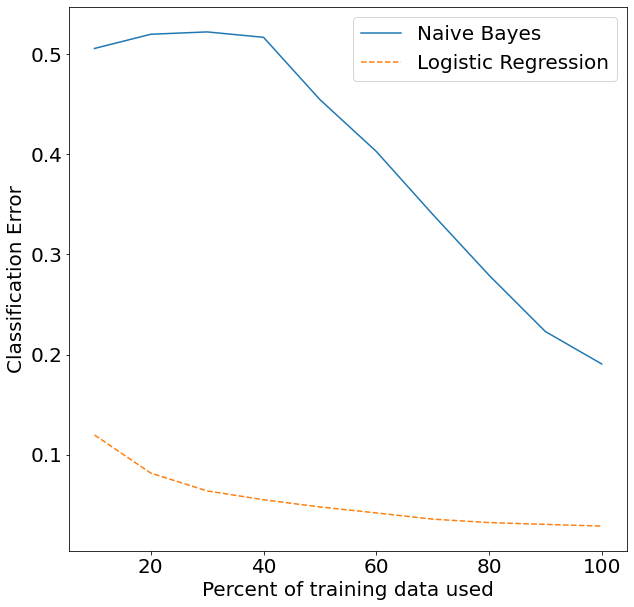

In [69]:
# load the dataset
# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
voting = pd.read_csv('./datasets/voting.csv')
#voting.info()
voting = voting.dropna(axis = 0, how = 'any')
voting = voting.reset_index(drop=True)
voting = voting.replace(to_replace = ['y','n'],value = [1, 0])

X = np.array(voting[voting.columns[1:]].values)
y = np.array(voting['label'])

shuffler = np.random.RandomState(seed=42).permutation(X.shape[0])
X = X[shuffler[:100]]
y = y[shuffler[:100]]

nbc_voting = NBC(feature_types=['b'] * 16)
lr_voting = LogisticRegression(solver='newton-cg')
tst_errs_nbc_voting, tst_errs_lr_voting = compareNBCvsLR(nbc_voting, lr_voting, X, y, num_runs=1000)
makePlot(tst_errs_nbc_voting, tst_errs_lr_voting)
###################################################
##### YOUR CODE ENDS HERE #########################
###################################################

Firstly I delete all missing values. The values of 16 feactures are 'y' or 'n'(only two values), so I change the values to '1' or '0' and assume they are binary distributed. Then I randomly choose 100 data points from the dataset, and set the seed to make sure every run is using the same data points. In this example, the logistic regression performs better than NBC in all time. But as more data points is being used, NBC's error rate decreases.